In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple

### Linear syntehic data generator

In [4]:
def generate_synthetic_data(n_samples=1000, x_range=(-3, 3), noise_type='homoscedastic', 
                           sigma_homo=0.20, sigma_hetero_base=0.10, sigma_hetero_amplitude=0.2,
                           function_type='linear', random_seed=42):
    """
    Generate synthetic regression data with controllable noise distribution.
    
    Parameters:
    -----------
    n_samples : int, default=1000
        Number of samples to generate
        
    x_range : tuple, default=(-3, 3)
        Range for x values (min, max)
        
    noise_type : str, default='homoscedastic'
        Type of noise: 'homoscedastic' or 'heteroscedastic'
        
    sigma_homo : float, default=0.20
        Standard deviation for homoscedastic noise
        
    sigma_hetero_base : float, default=0.10
        Base standard deviation for heteroscedastic noise
        
    sigma_hetero_amplitude : float, default=0.2
        Amplitude of the sinusoidal component for heteroscedastic noise
        
    function_type : str, default='linear'
        Type of function: 'linear' (flin(x) = 0.7x + 0.5)
        
    random_seed : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    x : numpy.ndarray
        Input features
        
    y : numpy.ndarray
        Target values
        
    sigma : numpy.ndarray
        Noise standard deviation for each point
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Generate x values uniformly in the specified range
    x = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    # Define the function (currently only linear, but can be extended)
    if function_type == 'linear':
        # flin(x) = 0.7x + 0.5
        y_true = 0.7 * x + 0.5
    else:
        raise ValueError(f"Function type '{function_type}' not implemented yet")
    
    # Generate noise based on type
    if noise_type == 'homoscedastic':
        # Constant noise: σ(x) = sigma_homo
        sigma = np.full(n_samples, sigma_homo)
        epsilon = np.random.normal(0, sigma_homo, n_samples)
        
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic noise: σ(x) = 0.10 + 0.2(0.5 + 0.5 sin x)
        sigma = sigma_hetero_base + sigma_hetero_amplitude * (0.5 + 0.5 * np.sin(x))
        epsilon = np.random.normal(0, sigma)
        
    else:
        raise ValueError(f"Noise type '{noise_type}' not supported. Use 'homoscedastic' or 'heteroscedastic'")
    
    # Generate final y values: y = f(x) + ε
    y = y_true + epsilon
    
    return x, y, sigma


In [5]:
# Example usage: Generate homoscedastic data
x_homo, y_homo, sigma_homo = generate_synthetic_data(
    n_samples=500, 
    x_range=(-3, 3), 
    noise_type='homoscedastic', 
    sigma_homo=0.20,
    random_seed=42
)

print(f"Generated {len(x_homo)} samples with homoscedastic noise")
print(f"X range: [{x_homo.min():.3f}, {x_homo.max():.3f}]")
print(f"Y range: [{y_homo.min():.3f}, {y_homo.max():.3f}]")
print(f"Constant sigma: {sigma_homo[0]:.3f}")


Generated 500 samples with homoscedastic noise
X range: [-2.970, 2.958]
Y range: [-1.874, 2.911]
Constant sigma: 0.200


In [6]:
# Example usage: Generate heteroscedastic data
x_hetero, y_hetero, sigma_hetero = generate_synthetic_data(
    n_samples=500, 
    x_range=(-3, 3), 
    noise_type='heteroscedastic', 
    sigma_hetero_base=0.10,
    sigma_hetero_amplitude=0.2,
    random_seed=42
)

print(f"Generated {len(x_hetero)} samples with heteroscedastic noise")
print(f"X range: [{x_hetero.min():.3f}, {x_hetero.max():.3f}]")
print(f"Y range: [{y_hetero.min():.3f}, {y_hetero.max():.3f}]")
print(f"Sigma range: [{sigma_hetero.min():.3f}, {sigma_hetero.max():.3f}]")


Generated 500 samples with heteroscedastic noise
X range: [-2.970, 2.958]
Y range: [-1.834, 2.953]
Sigma range: [0.100, 0.300]


In [7]:
# Visualization function
def plot_synthetic_data(x, y, sigma, title="Synthetic Data", show_sigma=True):
    """Plot the generated synthetic data with optional sigma visualization."""
    
    fig, axes = plt.subplots(1, 2 if show_sigma else 1, figsize=(12, 5))
    if not show_sigma:
        axes = [axes]
    
    # Sort data for better visualization
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    sigma_sorted = sigma[sort_idx]
    
    # Plot 1: Data points with true function
    ax1 = axes[0]
    ax1.scatter(x, y, alpha=0.6, s=20, label='Data points')
    
    # Plot true function
    x_true = np.linspace(x.min(), x.max(), 100)
    y_true = 0.7 * x_true + 0.5
    ax1.plot(x_true, y_true, 'r-', linewidth=2, label='True function: f(x) = 0.7x + 0.5')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'{title} - Data Points')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if show_sigma:
        # Plot 2: Noise standard deviation
        ax2 = axes[1]
        ax2.scatter(x_sorted, sigma_sorted, alpha=0.6, s=20, color='orange')
        ax2.set_xlabel('x')
        ax2.set_ylabel('σ(x)')
        ax2.set_title(f'{title} - Noise Standard Deviation')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Homoscedastic Data:


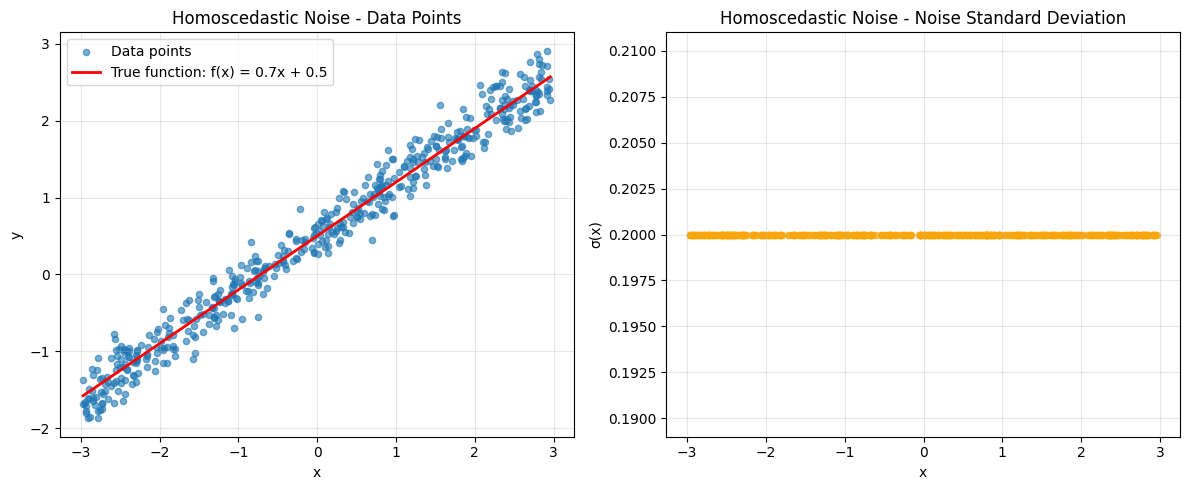


Heteroscedastic Data:


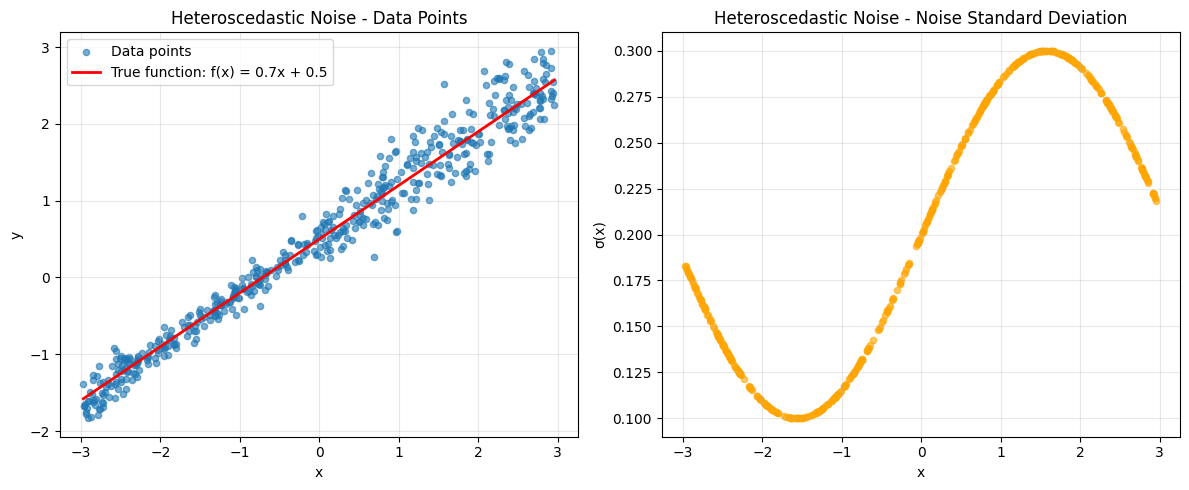

In [8]:
# Visualize the generated data
print("Homoscedastic Data:")
plot_synthetic_data(x_homo, y_homo, sigma_homo, "Homoscedastic Noise")

print("\nHeteroscedastic Data:")
plot_synthetic_data(x_hetero, y_hetero, sigma_hetero, "Heteroscedastic Noise")


## MC Droput

In [9]:

# 1) Losses per Section 3.1 (Eq. 4 and Eq. 5)
def gaussian_nll(y, mu, log_var, reduction="mean", eps=1e-8):
    """
    Standard Gaussian NLL: log(σ²) + (y - μ)² / (2 σ²)
    Matches Eq. (4) in the paper【6-6】.
    """
    var = torch.exp(log_var) + eps
    nll = torch.log(var) + (y - mu)**2 / (2.0 * var)
    if reduction == "mean":
        return nll.mean()
    elif reduction == "sum":
        return nll.sum()
    else:
        return nll

def beta_gaussian_nll(y, mu, log_var, beta=0.5, reduction="mean", eps=1e-8):
    """
    β-NLL: stop(σ²^β) * NLL (Eq. 5)【6-6】.
    Helps mitigate variance underestimation (variance attenuation).
    """
    var = torch.exp(log_var) + eps
    base = gaussian_nll(y, mu, log_var, reduction="none", eps=eps)
    weight = (var ** beta).detach()  # stop-gradient
    nll = weight * base
    if reduction == "mean":
        return nll.mean()
    elif reduction == "sum":
        return nll.sum()
    else:
        return nll

# 2) MC Dropout model predicting μ and log σ²
class MCDropoutRegressor(nn.Module):
    def __init__(self, in_features: int, hidden: int = 64, p: float = 0.25):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(hidden, hidden)
        self.drop2 = nn.Dropout(p)
        # Heads: mean and log-variance
        self.mu_head = nn.Linear(hidden, 1)
        self.logvar_head = nn.Linear(hidden, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        mu = self.mu_head(x).squeeze(-1)          # [N]
        log_var = self.logvar_head(x).squeeze(-1) # [N]
        return mu, log_var

# 3) Training loop
def train_mc_dropout(
    X_train, y_train, 
    X_val=None, y_val=None,
    hidden=64, p=0.25, beta=0.5,  # set beta=None to use standard NLL
    lr=1e-3, epochs=200, batch_size=128, device="cpu",
    weight_decay=0.0  # optional L2
):
    X_train = torch.as_tensor(X_train, dtype=torch.float32)
    y_train = torch.as_tensor(y_train, dtype=torch.float32)
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    in_features = X_train.shape[1]
    model = MCDropoutRegressor(in_features, hidden=hidden, p=p).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for ep in range(1, epochs + 1):
        model.train()  # keep dropout active during training
        total = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            mu, log_var = model(xb)
            if beta is None:
                loss = gaussian_nll(yb, mu, log_var, reduction="mean")
            else:
                loss = beta_gaussian_nll(yb, mu, log_var, beta=beta, reduction="mean")
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        avg = total / len(train_ds)

        if (ep % 20 == 0) or ep == 1:
            msg = f"Epoch {ep:3d} | train loss: {avg:.4f}"
            if X_val is not None and y_val is not None:
                Xv = torch.as_tensor(X_val, dtype=torch.float32).to(device)
                yv = torch.as_tensor(y_val, dtype=torch.float32).to(device)
                model.train()  # a single stochastic pass is fine for monitoring
                mu_v, logv_v = model(Xv)
                if beta is None:
                    val_loss = gaussian_nll(yv, mu_v, logv_v, reduction="mean").item()
                else:
                    val_loss = beta_gaussian_nll(yv, mu_v, logv_v, beta=beta, reduction="mean").item()
                msg += f" | val loss: {val_loss:.4f}"
            print(msg)
    return model

# 4) MC sampling and decomposition (Sec. 3.1)
@torch.no_grad()
def mc_decompose(
    model: nn.Module, 
    X: torch.Tensor, 
    mc_samples: int = 100, 
    device: str = "cpu"
):
    """
    Returns:
      mu_pred: [N] predictive mean E[μ_i]
      var_pred: [N] predictive variance E[σ_i²] + Var[μ_i]
      var_ale: [N] aleatoric = E[σ_i²]
      var_epi: [N] epistemic = Var[μ_i]
    """
    X = X.to(device)
    model.train()  # activate dropout for stochastic passes
    mu_s, var_s = [], []
    for _ in range(mc_samples):
        mu, log_var = model(X)
        mu_s.append(mu)
        var_s.append(torch.exp(log_var))
    mu_stack = torch.stack(mu_s, dim=0)     # [S, N]
    var_stack = torch.stack(var_s, dim=0)   # [S, N]

    mu_pred = mu_stack.mean(dim=0)                      # E[μ_i]
    var_ale = var_stack.mean(dim=0)                     # E[σ_i²]
    var_epi = mu_stack.var(dim=0, unbiased=False)       # Var[μ_i]
    var_pred = var_ale + var_epi
    return mu_pred, var_pred, var_ale, var_epi

# 5) Convenience: batch API for numpy users
def predict_with_uncertainty(model, X, mc_samples=100, device="cpu"):
    """
    numpy in -> numpy out convenience wrapper.
    """
    X_t = torch.as_tensor(X, dtype=torch.float32)
    with torch.no_grad():
        mu_pred, var_pred, var_ale, var_epi = mc_decompose(model, X_t, mc_samples=mc_samples, device=device)
    return (
        mu_pred.cpu().numpy(),
        var_pred.cpu().numpy(),
        var_ale.cpu().numpy(),
        var_epi.cpu().numpy(),
    )

# 6) Example usage
if __name__ == "__main__":
    # Synthetic 1D regression with heteroscedastic noise
    N = 1500
    X = torch.linspace(0, 10, N).unsqueeze(1)
    true_mu = X.squeeze() * torch.sin(X.squeeze())
    # Heteroscedastic: noise increases with x
    noise_std = 0.1 + 0.2 * (X.squeeze() / 10.0)
    y = true_mu + noise_std * torch.randn(N)

    # Split
    X_train, y_train = X[:1000], y[:1000]
    X_val, y_val = X[1000:], y[1000:]

    # Train with β-NLL (β=0.5 as in the toy example in the paper【6-11】)
    model = train_mc_dropout(
        X_train, y_train, X_val, y_val,
        hidden=64, p=0.25, beta=0.5,
        lr=1e-3, epochs=200, batch_size=128, device="cpu"
    )

    # MC inference + decomposition
    mu_pred, var_pred, var_ale, var_epi = predict_with_uncertainty(model, X_val, mc_samples=200)

    print("mu_pred[:5]:", mu_pred[:5])
    print("var_pred[:5]:", var_pred[:5])  # predictive variance
    print("var_ale [:5]:", var_ale[:5])   # aleatoric
    print("var_epi [:5]:", var_epi[:5])   # epistemic


Epoch   1 | train loss: 2.7134 | val loss: 15.7641
Epoch  20 | train loss: 1.7065 | val loss: 22.1196
Epoch  40 | train loss: 1.3182 | val loss: 22.6640
Epoch  60 | train loss: 0.9999 | val loss: 19.8356
Epoch  80 | train loss: 0.6581 | val loss: 16.5746
Epoch 100 | train loss: 0.3936 | val loss: 12.3727
Epoch 120 | train loss: 0.1420 | val loss: 11.7192
Epoch 140 | train loss: -0.0397 | val loss: 12.0832
Epoch 160 | train loss: -0.1428 | val loss: 13.5746
Epoch 180 | train loss: -0.2181 | val loss: 14.7495
Epoch 200 | train loss: -0.3135 | val loss: 16.1324
mu_pred[:5]: [1.1205649 1.1684793 1.1630014 1.1052089 1.210869 ]
var_pred[:5]: [1.6777208 1.889216  1.8541381 1.9049944 1.7871554]
var_ale [:5]: [0.529074   0.53723776 0.5400138  0.55037737 0.546663  ]
var_epi [:5]: [1.1486467 1.3519782 1.3141243 1.354617  1.2404925]


In [21]:
import torch
import matplotlib.pyplot as plt

def plot_total_uncertainty(
    X, mu_pred, var_pred, k=2.0, sort=True,
    title="Predictive mean with uncertainty band"
):
    """
    Plot μ*(x) with shaded ± k * sqrt(σ*²(x)) band.

    Args:
        X: inputs [N, D] or [N]; if D>1, first column used for sorting/plot.
        mu_pred: [N] predictive mean
        var_pred: [N] total variance
        k: bandwidth multiplier (e.g., 2.0 for ~95% band if normal)
        sort: sort by X for cleaner curve
        title: plot title
    """
    X = torch.as_tensor(X, dtype=torch.float32).squeeze()
    mu_pred = torch.as_tensor(mu_pred, dtype=torch.float32).squeeze()
    std_pred = torch.sqrt(torch.as_tensor(var_pred, dtype=torch.float32).squeeze())

    # If multi-D, plot against the first dimension
    if X.ndim > 1:
        X_plot = X[:, 0]
    else:
        X_plot = X

    # Sort by X for curve plotting
    if sort:
        idx = torch.argsort(X_plot)
        Xs = X_plot[idx].cpu().numpy()
        mus = mu_pred[idx].cpu().numpy()
        stds = std_pred[idx].cpu().numpy()
    else:
        Xs = X_plot.cpu().numpy()
        mus = mu_pred.cpu().numpy()
        stds = std_pred.cpu().numpy()

    plt.figure()
    plt.plot(Xs, mus, label="Predictive mean μ*(x)")
    plt.fill_between(Xs, mus - k*stds, mus + k*stds, alpha=0.3, label=f"± {k} · std")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_uncertainty_components(
    X, var_pred, var_ale, var_epi, sort=True,
    title="Uncertainty components"
):
    """
    Plot per-x uncertainty components as separate curves:
      - sqrt(total variance)
      - sqrt(aleatoric variance)
      - sqrt(epistemic variance)

    Args:
        X: inputs [N, D] or [N]; if D>1, first column used for sorting/plot.
        var_pred: [N] total variance
        var_ale: [N] aleatoric variance
        var_epi: [N] epistemic variance
        sort: sort by X for cleaner curve
        title: plot title
    """
    X = torch.as_tensor(X, dtype=torch.float32).squeeze()
    std_pred = torch.sqrt(torch.as_tensor(var_pred, dtype=torch.float32).squeeze())
    std_ale  = torch.sqrt(torch.as_tensor(var_ale,  dtype=torch.float32).squeeze())
    std_epi  = torch.sqrt(torch.as_tensor(var_epi,  dtype=torch.float32).squeeze())

    if X.ndim > 1:
        X_plot = X[:, 0]
    else:
        X_plot = X

    if sort:
        idx = torch.argsort(X_plot)
        Xs = X_plot[idx].cpu().numpy()
        sp = std_pred[idx].cpu().numpy()
        sa = std_ale[idx].cpu().numpy()
        se = std_epi[idx].cpu().numpy()
    else:
        Xs = X_plot.cpu().numpy()
        sp = std_pred.cpu().numpy()
        sa = std_ale.cpu().numpy()
        se = std_epi.cpu().numpy()

    plt.figure()
    plt.plot(Xs, sp, label="Total std √σ*²(x)")
    plt.plot(Xs, sa, label="Aleatoric std √E[σ²(x)]")
    plt.plot(Xs, se, label="Epistemic std √Var[μ(x)]")
    plt.xlabel("x")
    plt.ylabel("uncertainty (std)")
    plt.title(title)
    plt.legend()
    plt.show()


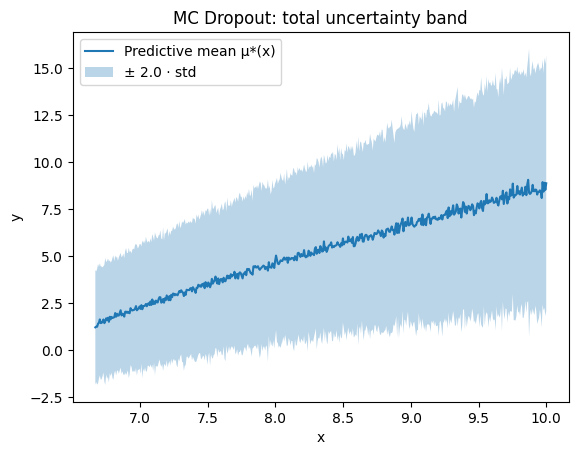

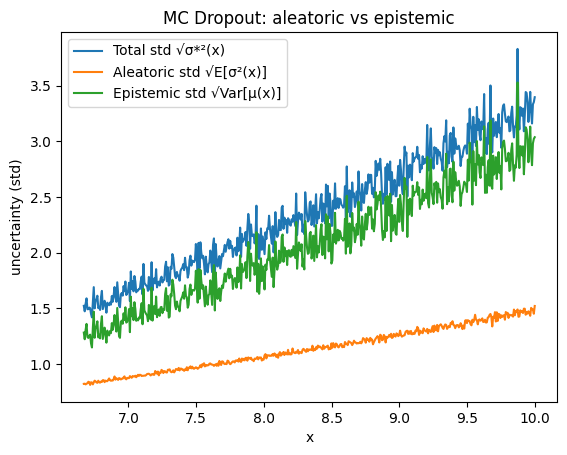

In [22]:
# After:
# mu_pred, var_pred, var_ale, var_epi = predict_with_uncertainty(model, X_val, mc_samples=200)

plot_total_uncertainty(X_val, mu_pred, var_pred, k=2.0, title="MC Dropout: total uncertainty band")
plot_uncertainty_components(X_val, var_pred, var_ale, var_epi, title="MC Dropout: aleatoric vs epistemic")


### Valdengero paper

In [23]:
import torch

def generate_valdenegro_toy_regression(
    n_train=1000,
    n_ood=200,
    x_train_range=(0.0, 10.0),
    x_ood_range=(10.0, 15.0),
    noise_std=0.3,
    seed=None,
    device="cpu"
):
    """
    Generate the toy regression dataset from Valdenegro-Toro & Mori (Sec. 4.2):
      f(x) = x * sin(x) + ε1 * x + ε2,  ε1, ε2 ~ N(0, noise_std)

    Default sizes/ranges match the paper: 1000 train in [0,10], 200 OOD in [10,15]【6-10】.
    """
    if seed is not None:
        torch.manual_seed(seed)

    def sample_x(n, rng):
        return torch.empty(n, 1, device=device).uniform_(rng[0], rng[1])

    def f(x):
        # x: [N,1]
        x1 = x.squeeze(-1)
        e1 = torch.randn_like(x1) * noise_std
        e2 = torch.randn_like(x1) * noise_std
        y = x1 * torch.sin(x1) + e1 * x1 + e2
        return y  # [N]

    X_train = sample_x(n_train, x_train_range)
    y_train = f(X_train)

    X_ood = sample_x(n_ood, x_ood_range)
    y_ood = f(X_ood)

    return (X_train, y_train), (X_ood, y_ood)

def true_function(x):
    """
    Noiseless ground truth μ(x) = x * sin(x), for plotting.
    """
    x = torch.as_tensor(x, dtype=torch.float32).squeeze()
    return x * torch.sin(x)


Epoch   1 | train loss: 6.9804 | val loss: 10.1771
Epoch  20 | train loss: 7.2624 | val loss: 8.3119
Epoch  40 | train loss: 6.6738 | val loss: 7.7679
Epoch  60 | train loss: 6.0342 | val loss: 6.8395
Epoch  80 | train loss: 5.9503 | val loss: 7.0363
Epoch 100 | train loss: 5.5994 | val loss: 6.5393
Epoch 120 | train loss: 5.4765 | val loss: 6.4473
Epoch 140 | train loss: 5.1582 | val loss: 5.8209
Epoch 160 | train loss: 4.9104 | val loss: 6.2537
Epoch 180 | train loss: 4.7233 | val loss: 5.6806
Epoch 200 | train loss: 4.6271 | val loss: 5.0388


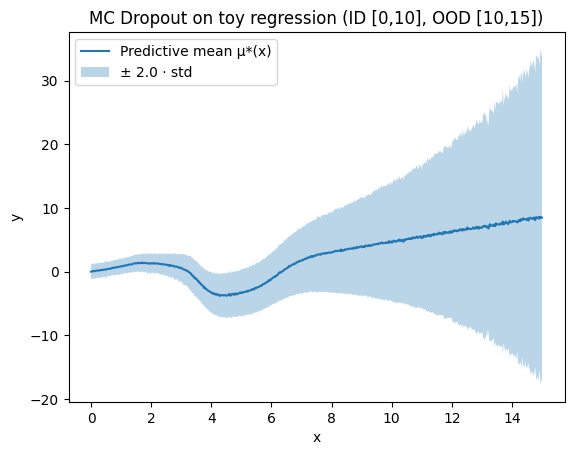

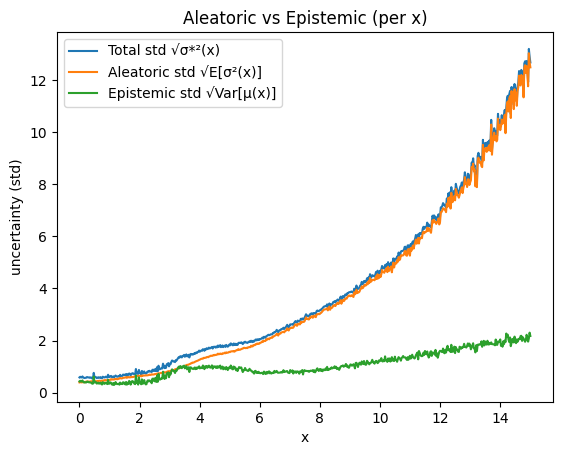

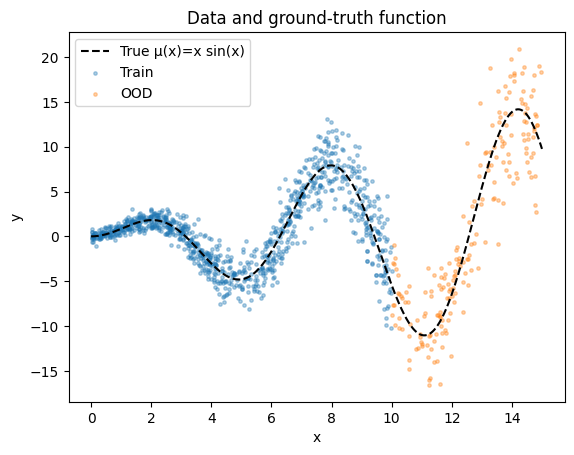

In [24]:
# Assuming you already defined:
# - MCDropoutRegressor
# - gaussian_nll / beta_gaussian_nll
# - train_mc_dropout
# - mc_decompose or predict_with_uncertainty
# - plot_total_uncertainty, plot_uncertainty_components

if __name__ == "__main__":
    device = "cpu"

    # 1) Generate data (matches Sec. 4.2 settings)【6-10】
    (X_train, y_train), (X_ood, y_ood) = generate_valdenegro_toy_regression(
        n_train=1000, n_ood=200, noise_std=0.3, seed=42, device=device
    )

    # Optional: create a validation split from train
    n_val = 200
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]
    X_tr, y_tr = X_train[:-n_val], y_train[:-n_val]

    # 2) Train MC Dropout model with β-NLL (β=0.5 as in the paper’s toy experiments)【6-11】
    model = train_mc_dropout(
        X_tr, y_tr, X_val, y_val,
        hidden=64, p=0.25, beta=0.5,
        lr=1e-3, epochs=200, batch_size=128, device=device
    )

    # 3) Evaluate on a dense grid for pretty plots (cover ID + OOD domain)
    X_plot = torch.linspace(0, 15, 600).unsqueeze(1)
    mu_pred, var_pred, var_ale, var_epi = mc_decompose(model, X_plot, mc_samples=200, device=device)

    # 4) Plot predictive mean with total uncertainty band
    plot_total_uncertainty(
        X_plot, mu_pred, var_pred, k=2.0,
        title="MC Dropout on toy regression (ID [0,10], OOD [10,15])"
    )

    # 5) Plot component uncertainties
    plot_uncertainty_components(
        X_plot, var_pred, var_ale, var_epi,
        title="Aleatoric vs Epistemic (per x)"
    )

    # Optional: overlay noiseless ground truth curve
    import matplotlib.pyplot as plt
    with torch.no_grad():
        y_true = true_function(X_plot)
    plt.figure()
    plt.plot(X_plot.squeeze().numpy(), y_true.numpy(), 'k--', label="True μ(x)=x sin(x)")
    plt.scatter(X_train.squeeze().numpy(), y_train.numpy(), s=6, alpha=0.35, label="Train")
    plt.scatter(X_ood.squeeze().numpy(), y_ood.numpy(), s=6, alpha=0.35, label="OOD")
    plt.legend(); plt.title("Data and ground-truth function"); plt.xlabel("x"); plt.ylabel("y"); plt.show()
